In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Other imports for processing data
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the Dataset

In [1]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2021-04-03 21:56:48--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.217.13.78, 2607:f8b0:4004:82a::200e
Connecting to drive.google.com (drive.google.com)|172.217.13.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/magfa3bh250utaefp8clns6n5kp7vg0k/1617486975000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2021-04-03 21:56:50--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/magfa3bh250utaefp8clns6n5kp7vg0k/1617486975000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 172.217.13.225, 2607:f8b0:4004:809::2001
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|172.217.13.225|:4

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

In [5]:
def create_lyrics_corpus(dataset, field):
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  dataset[field] = dataset[field].str.lower()
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')  
  
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  corpus = [l for l in corpus if l != '']
  return corpus

In [6]:
def tokenize_corpus(corpus, num_words=-1):
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

In [7]:
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

print(total_words)

2000


# Create Sequences and Labels

In [8]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))


input_sequences, labels = sequences[:,:-1], sequences[:,-1]

one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Train a better Text Generation Model

In [9]:
model = Sequential()

model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(20)))

model.add(Dense(total_words, 
                activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(input_sequences, 
                    one_hot_labels, 
                    epochs=100, 
                    verbose=1)

Epoch 1/100
1480/1480 [==============================] - 45s 8ms/step - loss: 6.2440 - accuracy: 0.0404
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6972 - accuracy: 0.0506
Epoch 3/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.4672 - accuracy: 0.0649
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.2932 - accuracy: 0.1001
Epoch 5/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.1220 - accuracy: 0.1189
Epoch 6/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.9390 - accuracy: 0.1326
Epoch 7/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.7703 - accuracy: 0.1505
Epoch 8/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.6150 - accuracy: 0.1681
Epoch 9/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.5070 - accuracy: 0.1790
Epoch 10/100
1480/1480 [==============================] - 12s 8m

# View the Training Graph

In [10]:
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.show()

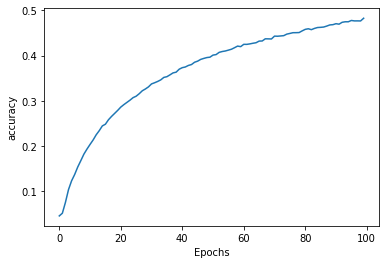

In [11]:
plot_graphs(history,'accuracy')

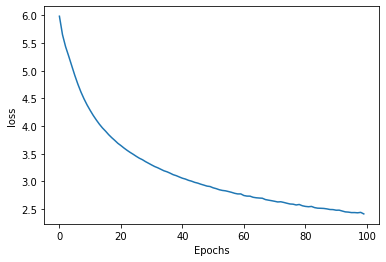

In [12]:
plot_graphs(history,'loss')

# Lets generate some better lyrics

In [13]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills the right of me a second chance while that tells me with the of your side diddle n ending was matter what it hurts and a road to me weve learned to meet to play it daddys natural and surprise goes line its something before you can be your way that i could do i think you know i am good baby to see it out of heaven i can see in my mind long sunny combination tambourine tambourine following machine machine happiest moon fool bill ends lead the candy to be so cold oh high high and soldiers wildest


# Varying the Possible Outputs

In [14]:
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

9


In [15]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills to stay by what the will are gone run here feet while its dont do it didnt ya need you now or more try to share all all rain regrets pride thing to answer the local police house youre matter what i seem in care for knows the truth told of rain ancient men seem to be done care make me the circle make me more learned is it has compared to rikky but that that began to move but i can play it right at nothin for me with a every time is playing penny roller livin live combination
